In [44]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torchvision import models, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import os
import pytesseract
from PIL import Image
import tensorflow as tf


In [45]:
class_folders = {
    "Birth Certificate": "/kaggle/input/gibl-ai-ml-hackathon-2025/ImagePDFClassification/Image Classification/Birth Certificate",
    "Blank": "/kaggle/input/gibl-ai-ml-hackathon-2025/ImagePDFClassification/Image Classification/Blank",
    "Citizenship": "/kaggle/input/gibl-ai-ml-hackathon-2025/ImagePDFClassification/Image Classification/Citizenship",
    "NID": "/kaggle/input/gibl-ai-ml-hackathon-2025/ImagePDFClassification/Image Classification/NID",
    "PAN": "/kaggle/input/gibl-ai-ml-hackathon-2025/ImagePDFClassification/Image Classification/PAN"
}

data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.1),
    RandomZoom(0.1)
])

img_height = 224
img_width = 224

transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def load_and_preprocess_image(path):
    img = Image.open(path).convert("RGB").resize((224, 224))
    img = np.array(img)
    img = data_augmentation(tf.convert_to_tensor(img[np.newaxis, ...]))
    return preprocess_input(img[0].numpy())

def extract_text_from_image(path):
    return pytesseract.image_to_string(Image.open(path))


In [46]:
# For TensorFlow
import tensorflow as tf
print("TensorFlow GPU Available:", len(tf.config.experimental.list_physical_devices('GPU')) > 0)

# For PyTorch
import torch
print("PyTorch GPU Available:", torch.cuda.is_available())

TensorFlow GPU Available: True
PyTorch GPU Available: True


In [47]:
images, texts, labels = [], [], []
label_map = {cls: idx for idx, cls in enumerate(class_folders)}

for cls, folder in class_folders.items():
    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        if file.lower().endswith(('jpg', 'jpeg', 'png')):
            images.append(load_and_preprocess_image(path))
            texts.append(extract_text_from_image(path))
            labels.append(label_map[cls])

images = np.array(images)
labels = np.array(labels)


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/gibl-ai-ml-hackathon-2025/ImagePDFClassification/Image Classification/Birth Certificate'

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [ ]:
images, texts, labels = [], [], []
label_map = {cls: idx for idx, cls in enumerate(class_folders)}

for cls, folder in class_folders.items():
    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        if file.lower().endswith(('jpg', 'jpeg', 'png')):
            images.append(load_and_preprocess_image(path))
            texts.append(extract_text_from_image(path))
            labels.append(label_map[cls])

images = np.array(images)
labels = np.array(labels)


In [ ]:
vectorizer = TfidfVectorizer(max_features=500)
text_features = vectorizer.fit_transform(texts).toarray()
y_cat = to_categorical(labels)


In [ ]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet.trainable = False
img_features = resnet.predict(images, verbose=1)
img_features = img_features.reshape(img_features.shape[0], -1)

X_combined = np.concatenate([img_features, text_features], axis=1)


In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y_cat, test_size=0.2, stratify=y_cat, random_state=42
)
    

In [49]:
input_layer = Input(shape=(X_combined.shape[1],))
x = Dense(512, activation='relu')(input_layer)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(5, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [50]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.5269 - loss: 9.3209 - val_accuracy: 0.8182 - val_loss: 2.3893
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9003 - loss: 2.6390 - val_accuracy: 0.9091 - val_loss: 0.5693
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9638 - loss: 0.8040 - val_accuracy: 0.9455 - val_loss: 1.2481
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9830 - loss: 0.3012 - val_accuracy: 0.9455 - val_loss: 0.6513
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9793 - loss: 0.1429 - val_accuracy: 0.9091 - val_loss: 3.7835
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9818 - loss: 0.2732 - val_accuracy: 0.9273 - val_loss: 0.8831
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9843 - loss: 0.1278 - val_accuracy: 0.9273 - val_loss: 3.9522
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9874 - loss: 0.1476 - val_accuracy: 0.8909 - 

In [51]:
def preprocess_single_image(image_path):
    img = Image.open(image_path).convert("RGB").resize((224, 224))
    img = np.array(img)
    img = data_augmentation(tf.convert_to_tensor(img[np.newaxis, ...]))
    img = preprocess_input(img[0].numpy())
    return img

def extract_text(image_path):
    return pytesseract.image_to_string(Image.open(image_path))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        19
           1       1.00      1.00      1.00        54
           2       0.88      0.95      0.91        22
           3       0.95      0.90      0.93        21
           4       0.95      0.91      0.93        22

    accuracy                           0.95       138
   macro avg       0.93      0.93      0.93       138
weighted avg       0.95      0.95      0.95       138



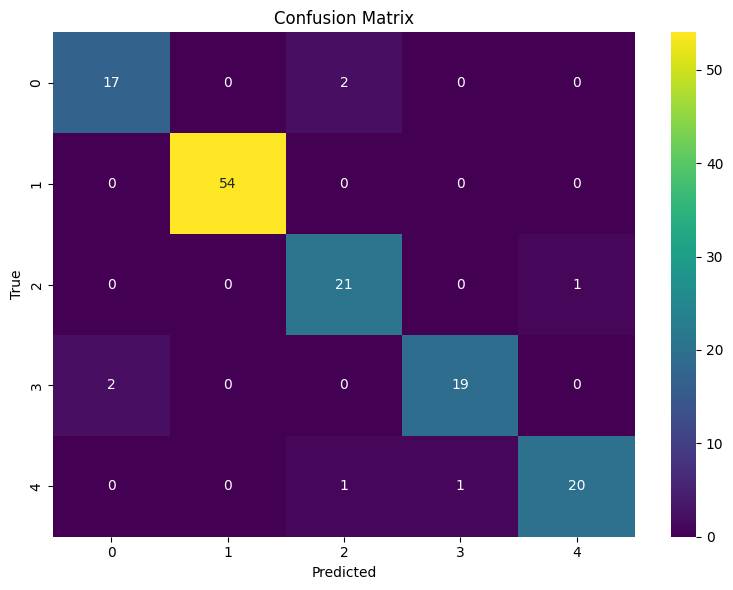

In [52]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Classification Report
print(classification_report(y_true_labels, y_pred_labels))

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=range(5), yticklabels=range(5))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


In [55]:
# Image
src = '/kaggle/input/bnalkkkkkkkkkkkkkkkk/WhatsApp Image 2025-05-01 at 18.05.55.jpeg'

test_img = preprocess_single_image(src)
test_img = np.expand_dims(test_img, axis=0)

# Image features
img_feature = resnet.predict(test_img)
img_feature = img_feature.reshape(img_feature.shape[0], -1)

# Text
test_text = extract_text(src)
text_feature = vectorizer.transform([test_text]).toarray()

# Combine features
test_input = np.concatenate([img_feature, text_feature], axis=1)

prediction = model.predict(test_input)
predicted_class = np.argmax(prediction)

# If you want to print the class name:
label_map_reverse = {v: k for k, v in label_map.items()}
print("Predicted Class:", label_map_reverse[predicted_class])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Class: PAN


In [56]:
import tensorflow as tf

# Assuming 'model' is your trained Keras model object
model.save('/kaggle/working/my_model.keras')

In [61]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
import pytesseract


# Load the saved model
model = tf.keras.models.load_model('/kaggle/working/my_model.keras')

# Load and preprocess the unseen image
def preprocess_single_image(image_path):
    img = Image.open(image_path).convert("RGB").resize((224, 224))
    img = np.array(img)
    img = preprocess_input(img)  
    return img

# Extract text from the image
def extract_text(image_path):
    return pytesseract.image_to_string(Image.open(image_path))

# Path to your unseen image
unseen_image_path = '/kaggle/input/sjdksdjbskhd/dipcit.png'  # Replace with the actual path

# Preprocess the image
unseen_image = preprocess_single_image(unseen_image_path)
unseen_image = np.expand_dims(unseen_image, axis=0)  # Add batch dimension

# Extract text features
unseen_text = extract_text(unseen_image_path)

# Assuming 'vectorizer' is your pre-trained TF-IDF vectorizer
# vectorizer = TfidfVectorizer(max_features=500) # If not already defined

unseen_text_features = vectorizer.transform([unseen_text]).toarray()

# Assuming 'resnet' is your pre-trained ResNet50 model
# resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # If not already defined

# Extract image features
unseen_image_features = resnet.predict(unseen_image)
unseen_image_features = unseen_image_features.reshape(unseen_image_features.shape[0], -1)

# Combine features
unseen_combined_features = np.concatenate([unseen_image_features, unseen_text_features], axis=1)

# Make prediction
prediction = model.predict(unseen_combined_features)
predicted_class = np.argmax(prediction)

# Get the class label
label_map_reverse = {0: "Birth Certificate", 1: "Blank", 2: "Citizenship", 3: "NID", 4: "PAN"}  
# Replace with your actual label mapping
predicted_label = label_map_reverse[predicted_class]

print("Predicted Label:", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Predicted Label: Birth Certificate


In [62]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 100852)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │      51,636,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,109,137 (591.69 MB)

 Trainable params: 51,703,045 (197.23 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 103,406,092 (394.46 MB)